# Imports:
---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import numpy as np

import torch
import torch.nn as nn
# import torch.optim as optim
# import torchvision
# from ray import tune
from torch.utils.data import DataLoader, TensorDataset #, Dataset
# import torch.nn.functional as F

import wandb
import os
from sklearn.decomposition import PCA
import itertools
import io

from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA

import importlib
import functions as f
import random

In [2]:
# Reload the functions module after updates
importlib.reload(f)

<module 'functions' from '/home/cmdunham/ChemicalDataGeneration/models/functions.py'>

# Loading Data:
---

## Loading CARLS and CARL-Based Embedding Preds:
---

In [9]:
# Loading CARLS created with averages of multiple background spectra
file_path='/mnt/usb/cmdunham/preprocessed_ims_data/train_carls_avg_backgrounds.csv'
train_carls = pd.read_csv(file_path)
file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/val_carls_avg_backgrounds.csv'
val_carls = pd.read_csv(file_path)
file_path='/mnt/usb/cmdunham/preprocessed_ims_data/test_carls_avg_backgrounds.csv'
test_carls = pd.read_csv(file_path)

In [2]:
# Loading Encoder embedding predictions
file_path = '/mnt/usb/cmdunham/avg_bkg_carl_encoder_train_embeddings.csv'
train = pd.read_csv(file_path)
file_path = '/mnt/usb/cmdunham/avg_bkg_carl_encoder_val_embeddings.csv'
val = pd.read_csv(file_path)
file_path = '/mnt/usb/cmdunham/avg_bkg_carl_encoder_test_embeddings.csv'
test = pd.read_csv(file_path)

In [5]:
# currently carls and embeddings do not have labels to distinguish which were created with average bkg 1 vs 2. Need to add those earlier but this works for now.
carl_nums = [.1, .2] * int(len(train)/2)
# carl_nums = ['_1', '_2'] * int(len(train)/2)
# train['index'] =  train['index'].astype(str)
train['index'] =  train['index'] + carl_nums
# train_carls['index'] =  train_carls['index'].astype(str)
train_carls['index'] =  train_carls['index'] + carl_nums

carl_nums = [.1, .2] * int(len(val)/2)
# val['index'] =  val['index'].astype(str)
val['index'] =  val['index'] + carl_nums
# val_carls['index'] =  val_carls['index'].astype(str)
val_carls['index'] =  val_carls['index'] + carl_nums

carl_nums = [.1, .2] * int(len(test)/2)
# test['index'] =  test['index'].astype(str)
test['index'] =  test['index'] + carl_nums
# test_carls['index'] =  test_carls['index'].astype(str)
test_carls['index'] =  test_carls['index'] + carl_nums

# val['bkg_idx'] = [1, 2] * int(len(val)/2)
# test['bkg_idx'] = [1, 2] * int(len(test)/2)
# train_carls['bkg_idx'] = [1, 2] * int(len(train_carls)/2)
# val_carls['bkg_idx'] = [1, 2] * int(len(val_carls)/2)
# test_carls['bkg_idx'] = [1, 2] * int(len(test_carls)/2)

val_carls.head()

,index,p_184,p_185,p_186,p_187,p_188,p_189,p_190,p_191,p_192,...,n_1021,Label,DEB,DEM,DMMP,DPM,DtBP,JP8,MES,TEPO
0,655550.1,3.300003,1.779999,-1.099999,-6.099998,-9.519997,-12.300003,-14.300003,-15.400002,-16.679993,...,3.04,DEB,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,655550.2,7.199997,5.540001,2.660004,-2.459999,-5.900002,-8.059998,-9.540001,-10.199997,-10.820000,...,4.00,DEB,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,384167.1,3.300003,2.779999,4.900002,3.900002,3.480003,2.699997,0.699997,-1.400001,-2.679993,...,1.04,DEM,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,384167.2,7.199997,6.540001,8.660004,7.540001,7.099998,6.940002,5.459999,3.800003,3.180000,...,2.00,DEM,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1141374.1,-6.699997,-6.220001,-6.099998,-7.099998,-8.519997,-11.300003,-14.300003,-17.400002,-19.679993,...,-1.96,DMMP,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Loading ChemNet Embeddings:
---

In [3]:
file_path = '../data/name_smiles_embedding_file.csv'
name_smiles_embedding_df = pd.read_csv(file_path)

# set the df index to be the chemical abbreviations in col 'Unnamed: 0'
name_smiles_embedding_df.set_index('Unnamed: 0', inplace=True)
name_smiles_embedding_df.head()

,Name,SMILES,embedding
Unnamed: 0,,,
BKG,background,NaN,NaN
DEM,Diethyl Malonate,CCOC(=O)CC(=O)OCC,"[0.3809721, 0.0005454041, 0.25539744, -0.24272..."
DEB,"1,2,3,4-Diepoxybutane",C1C(O1)C2CO2,"[0.06318794, 0.009022224, 0.42160064, 0.195722..."
MES,2-(N-morpholino)ethanesulfonic acid,C1COCCN1CCS(=O)(=O)O,"[-0.32520828, 0.009838344, -0.15108332, 0.2845..."
DMMP,Dimethyl methylphosphonate,COP(=O)(C)OC,"[0.12106811, 0.00294244, -0.14450458, 0.072665..."


In [4]:
embedding_floats = []
for chem_name in name_smiles_embedding_df.index:
    if chem_name == 'BKG':
        embedding_floats.append(None)
    else:
        embedding_float = name_smiles_embedding_df['embedding'][chem_name].split('[')[1]
        embedding_float = embedding_float.split(']')[0]
        embedding_float = [np.float32(num) for num in embedding_float.split(',')]
        embedding_floats.append(embedding_float)

name_smiles_embedding_df['Embedding Floats'] = embedding_floats

In [5]:
file_path = '../data/MoNA_embeddings_multiple_instrument_types.csv'
mass_spec_embeddings = pd.read_csv(file_path)
# mass_spec_embeddings = mass_spec_embeddings.rename(columns={
#     'METHYL PROPIONATE': 'Methyl Propionate', 'DIETHYL MALEATE':'Diethyl Maleate'
#     })

file_path = '../data/mass_spec_encoder_output.csv'
mass_spec_encoder_generated_embeddings = pd.read_csv(file_path)

In [20]:
# filtering out chems with < 5 embeddings
mass_spec_chem_counts = Counter(mass_spec_encoder_generated_embeddings['Label'])
chems_above_5 = [key for key, count in mass_spec_chem_counts.items() if count >= 5]
filtered_mass_spec_embeddings = mass_spec_embeddings[chems_above_5]
filtered_mass_spec_encoder_generated_embeddings = mass_spec_encoder_generated_embeddings[mass_spec_encoder_generated_embeddings['Label'].isin(chems_above_5)]

# Combine embeddings for IMS simulants and mass spec chems to use for plotting pca
ims_chemnet_embeddings = pd.DataFrame([emb for emb in name_smiles_embedding_df['Embedding Floats']][1:]).T
cols = name_smiles_embedding_df.index[1:]
ims_chemnet_embeddings.columns = cols
all_true_embeddings = pd.concat([ims_chemnet_embeddings, filtered_mass_spec_embeddings], axis=1)
all_true_embeddings.head()

,DEM,DEB,MES,DMMP,DPM,JP8,TEPO,DtBP,Glycine,Tryptophan,...,Succinic Acid,Malonic Acid,L-Lysine,Undecane,L-Asparagine,Testosterone,L-Alanine,Fluorene,2-Octanol,Gamma-Amino-N-Butyric Acid
0,0.380972,0.063188,-0.325208,0.121068,-0.023968,0.025142,0.193039,0.226090,0.012962,0.094619,...,0.064590,0.104017,-0.008052,0.110134,0.191296,-0.028562,0.121412,0.499569,-0.243301,0.012944
1,0.000545,0.009022,0.009838,0.002942,0.002720,0.011977,0.000974,0.000808,0.003898,0.001532,...,0.035480,0.060536,0.012390,0.000952,0.005387,0.063791,0.005075,-0.003935,0.004697,0.008486
2,0.255397,0.421601,-0.151083,-0.144505,0.158301,0.542705,0.066288,-0.062160,-0.179823,0.048508,...,-0.251732,-0.260941,0.077747,-0.037645,-0.178066,-0.061395,-0.331054,0.206176,-0.108382,-0.003481
3,-0.242728,0.195723,0.284503,0.072665,-0.010084,0.364973,-0.195223,-0.045343,0.618586,-0.228242,...,0.044983,0.027383,0.442515,-0.432724,0.447277,-0.363461,0.078999,0.408699,-0.401711,0.426480
4,-0.305106,-0.167326,-0.099838,-0.107286,-0.067723,-0.236272,-0.272051,-0.075880,-0.028876,-0.069579,...,-0.010591,-0.017281,-0.037480,-0.025410,-0.039142,-0.457587,-0.010997,-0.009848,-0.045440,-0.037688


# Creating Chemical "Regions" for Selecting New Embeddings:
---

In [26]:
# file_path = '/mnt/usb/cmdunham/avg_bkg_carl_encoder_test_embeddings.csv'
# test = pd.read_csv(file_path)
# labels = test.iloc[:,-8:].idxmax(axis=1)
# test['Label'] = labels
# file_path = '/mnt/usb/cmdunham/avg_bkg_carl_encoder_train_embeddings.csv'
# train = pd.read_csv(file_path)
labels = train.iloc[:,-8:].idxmax(axis=1)
train['Label'] = labels

In [ ]:
# ims_embeddings = pd.DataFrame([emb for emb in name_smiles_embedding_df['Embedding Floats']][1:]).T
# cols = name_smiles_embedding_df.index[1:]
# ims_embeddings.columns = cols

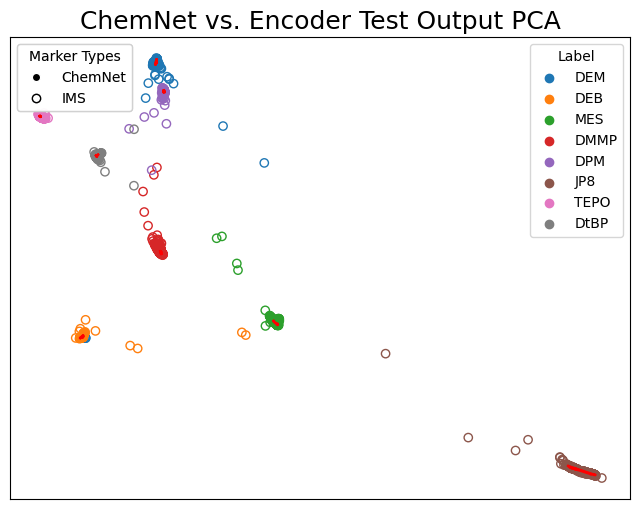

In [24]:
# Reload the functions module after updates
importlib.reload(f)
embeddings_only = test.iloc[:,1:-9]
embeddings_only.columns = ims_chemnet_embeddings.T.columns
embeddings_only['Label'] = test['Label']
f.plot_emb_pca(
    all_true_embeddings, embeddings_only, 'Test', 'IMS', 
    log_wandb=False, chemnet_embeddings_to_plot=ims_chemnet_embeddings,
    show_wandb_run_name=False, plot_hulls=True)

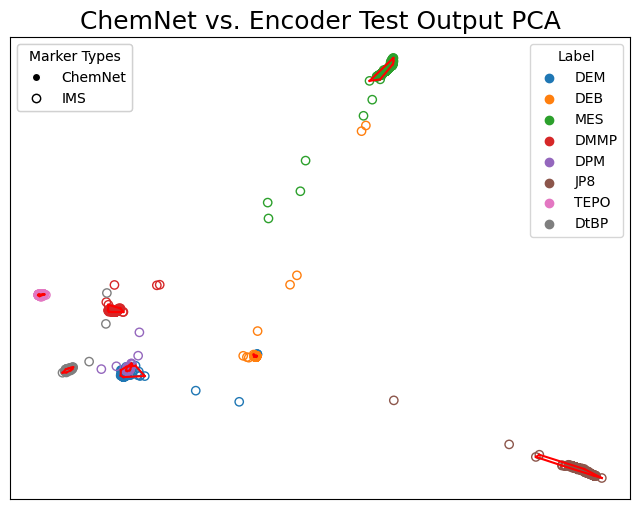

In [ ]:
# Reload the functions module after updates
importlib.reload(f)
embeddings_only = test.iloc[:,1:-9]
embeddings_only.columns = ims_chemnet_embeddings.T.columns
embeddings_only['Label'] = test['Label']
f.plot_emb_pca(ims_chemnet_embeddings, embeddings_only, 'Test', 'IMS', log_wandb=False, show_wandb_run_name=False, plot_hulls=True)

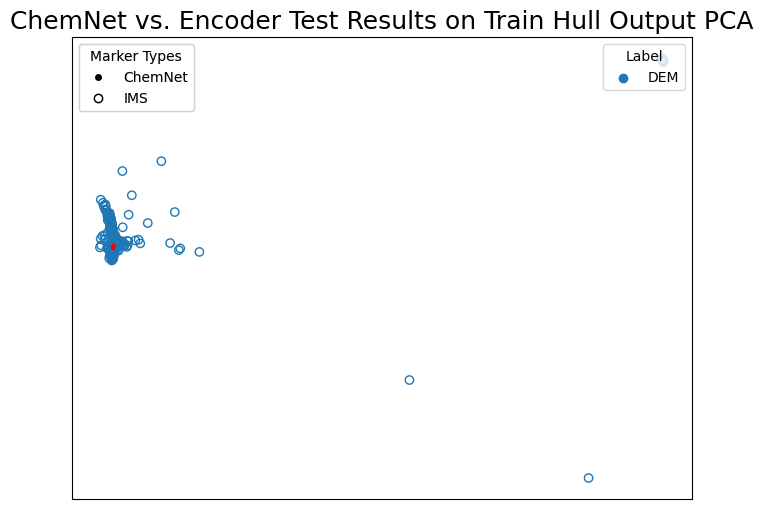

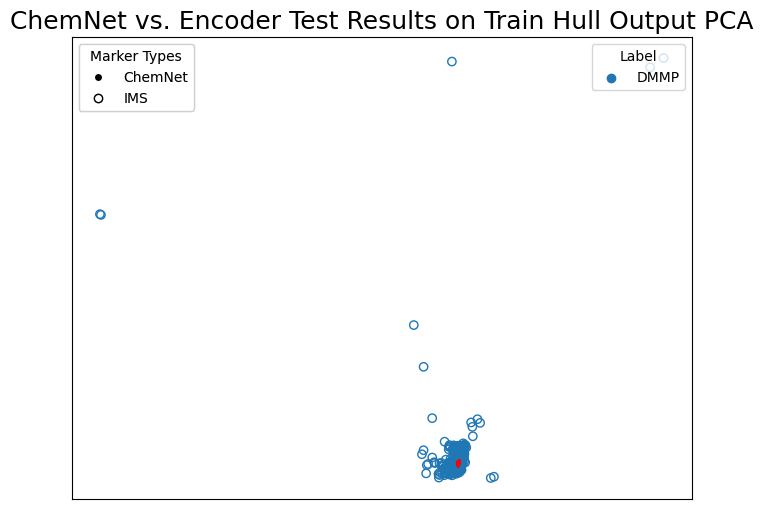

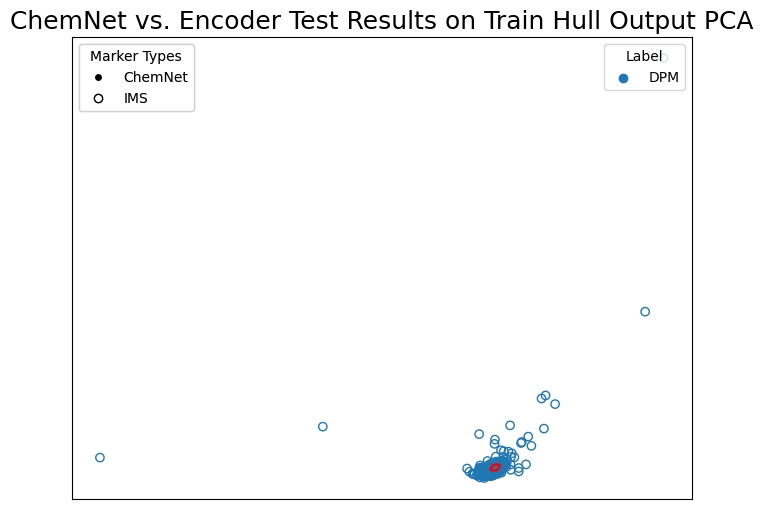

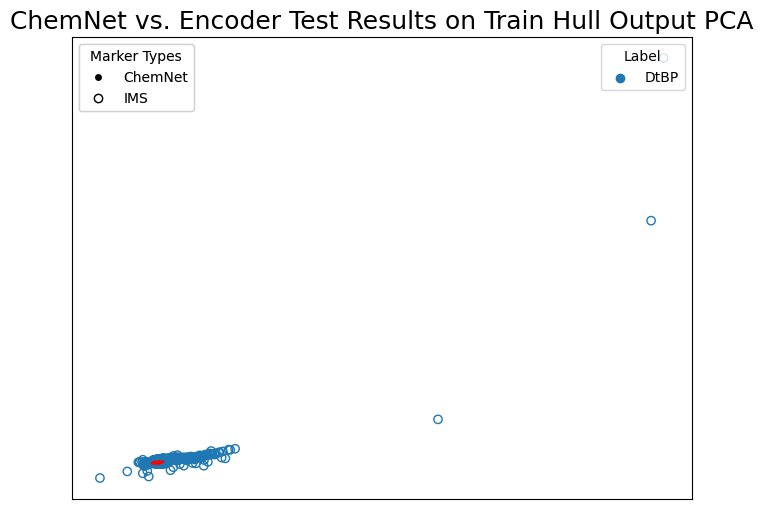

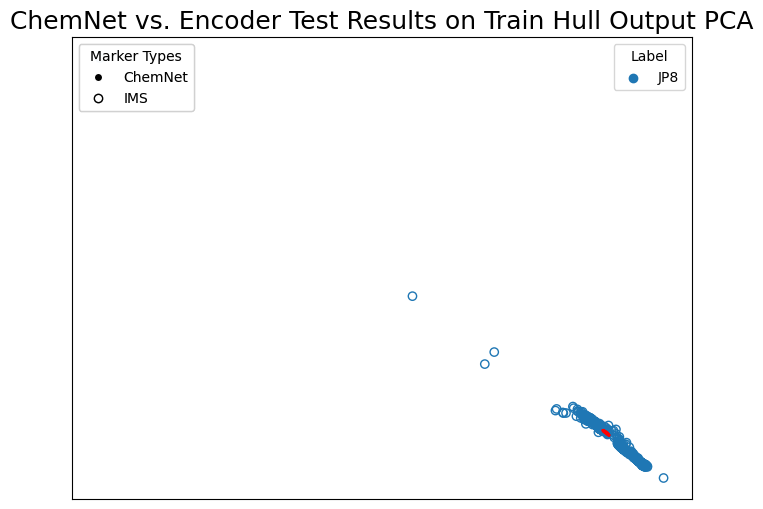

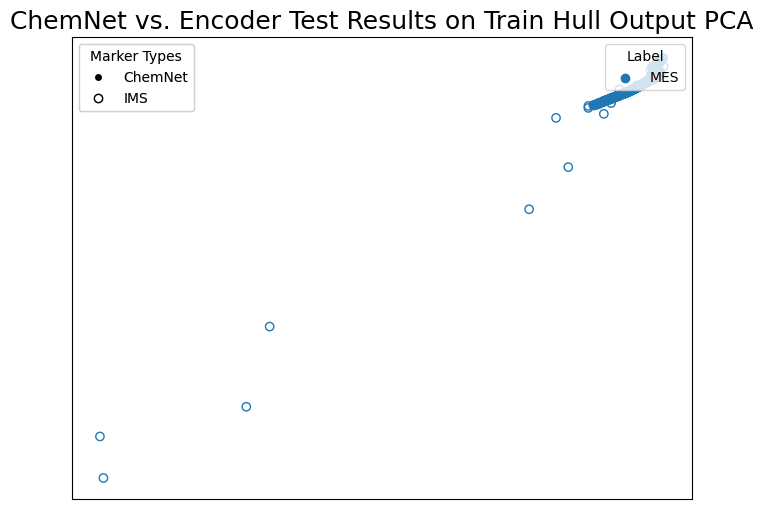

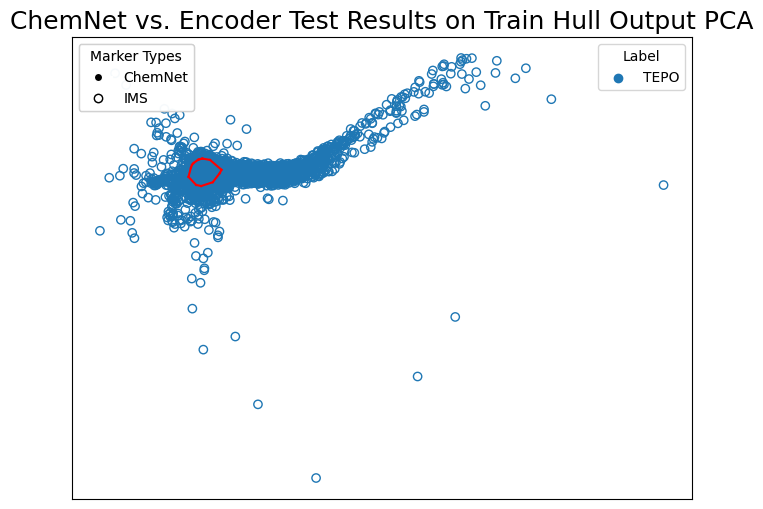

In [33]:
# Reload the functions module after updates
importlib.reload(f)
chems = train.columns[-8:-1]
train_embeddings_only = train.iloc[:,1:-9]
train_embeddings_only.columns = ims_chemnet_embeddings.T.columns
train_embeddings_only['Label'] = train['Label']
for chem in chems:
    chem_embeddings = embeddings_only[embeddings_only['Label'] == chem]
    chemnet_embeddings_to_plot = pd.DataFrame(ims_chemnet_embeddings[chem])
    f.plot_emb_pca(
        ims_chemnet_embeddings, chem_embeddings, 'Test Results on Train Hull', 'IMS', log_wandb=False, 
        chemnet_embeddings_to_plot=chemnet_embeddings_to_plot, 
        show_wandb_run_name=False, plot_hulls=True, hull_data=train_embeddings_only
        )

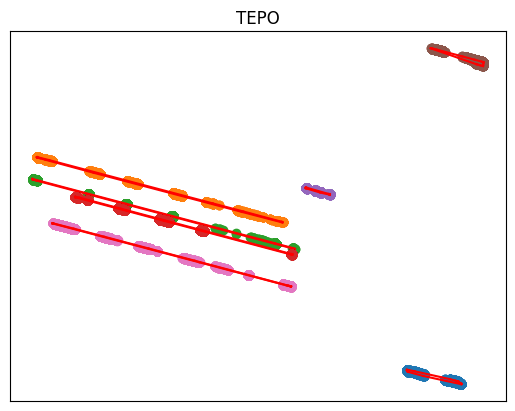

In [ ]:
# def plot_hulls(data):
#     pca = PCA(n_components=2)
#     pca.fit_transform(data.iloc[:,:-9])

#     chems = data.columns[-8:-1]

#     for chem in chems:
#         chem_data = data[data['Label'] == chem]
#         z_scores = np.abs(zscore(chem_data.iloc[:,:-9]))
#         threshold = 3  # Adjust threshold as needed

#         # Exclude outliers
#         filtered_data = chem_data[(z_scores < threshold).all(axis=1)]

#         transformed_data = pca.transform(filtered_data.iloc[:,:-9])
#         hull = ConvexHull(transformed_data)
#         plt.plot(transformed_data[:, 0], transformed_data[:, 1], 'o')  # Plot points
#         for simplex in hull.simplices:
#             plt.plot(transformed_data[simplex, 0], transformed_data[simplex, 1], 'r-') 
#         plt.xticks([])
#         plt.yticks([])
#         # plt.title(chem)
#     plt.show()
# plot_hulls(test)

# Training Generator:
---

In [28]:
# Reload the functions module after updates
importlib.reload(f)

<module 'functions' from '/home/cmdunham/ChemicalDataGeneration/models/functions.py'>

In [3]:
device = f.set_up_gpu()

Selected GPU ID: 1
  Name: NVIDIA GeForce RTX 4090
  Memory Free: 24203.0 MB
  Memory Used: 14.0 MB
  GPU Load: 0.00%
Current device ID:  cuda:1
PyTorch current device ID: 1
PyTorch current device name: NVIDIA GeForce RTX 4090


In [11]:
train_embeddings_tensor, train_carl_tensor, train_chem_encodings_tensor, train_carl_indices_tensor = f.create_dataset_tensors_for_generator(train_carls, train, device)
val_embeddings_tensor, val_carl_tensor, val_chem_encodings_tensor, val_carl_indices_tensor = f.create_dataset_tensors_for_generator(val_carls, val, device)
test_embeddings_tensor, test_carl_tensor, test_chem_encodings_tensor, test_carl_indices_tensor = f.create_dataset_tensors_for_generator(test_carls, test, device)

In [12]:
# Things that need to be changed for each generator/dataset/target carl
notebook_name = '/home/cmdunham/ChemicalDataGeneration/models/ims_generator.ipynb'
architecture = 'carl_generator'
dataset_type = 'carls'
target_embedding = 'ChemNet'
generator_path = '../models/carl_to_chemnet_generator.pth'

config = {
    'wandb_entity': 'catemerfeld',
    'wandb_project': 'ims_encoder_decoder',
    'gpu':True,
    'threads':1,
}

os.environ['WANDB_NOTEBOOK_NAME'] = notebook_name

In [33]:
# Reload the functions module after updates
importlib.reload(f)

<module 'functions' from '/home/cmdunham/ChemicalDataGeneration/models/functions.py'>

Using device: cuda
--------------------------
--------------------------
New run with hyperparameters:
batch_size  :  16
epochs  :  100
learning_rate  :  0.01
Saved best model at epoch 0
Epoch[1/100]:
   Training loss: 5902040251449.5
   Validation loss: 160088.42842319282
-------------------------------------------
Saved best model at epoch 5
Epoch[10/100]:
   Training loss: 167035.65277587407
   Validation loss: 157776.51359604186
-------------------------------------------
Epoch 00012: reducing learning rate of group 0 to 1.0000e-03.
Saved best model at epoch 13
Saved best model at epoch 14
Epoch[20/100]:
   Training loss: 14066.375011011123
   Validation loss: 71240.09778242794
-------------------------------------------
Epoch 00021: reducing learning rate of group 0 to 1.0000e-04.
Validation loss has not improved in 10 epochs. Stopping training at epoch 25.


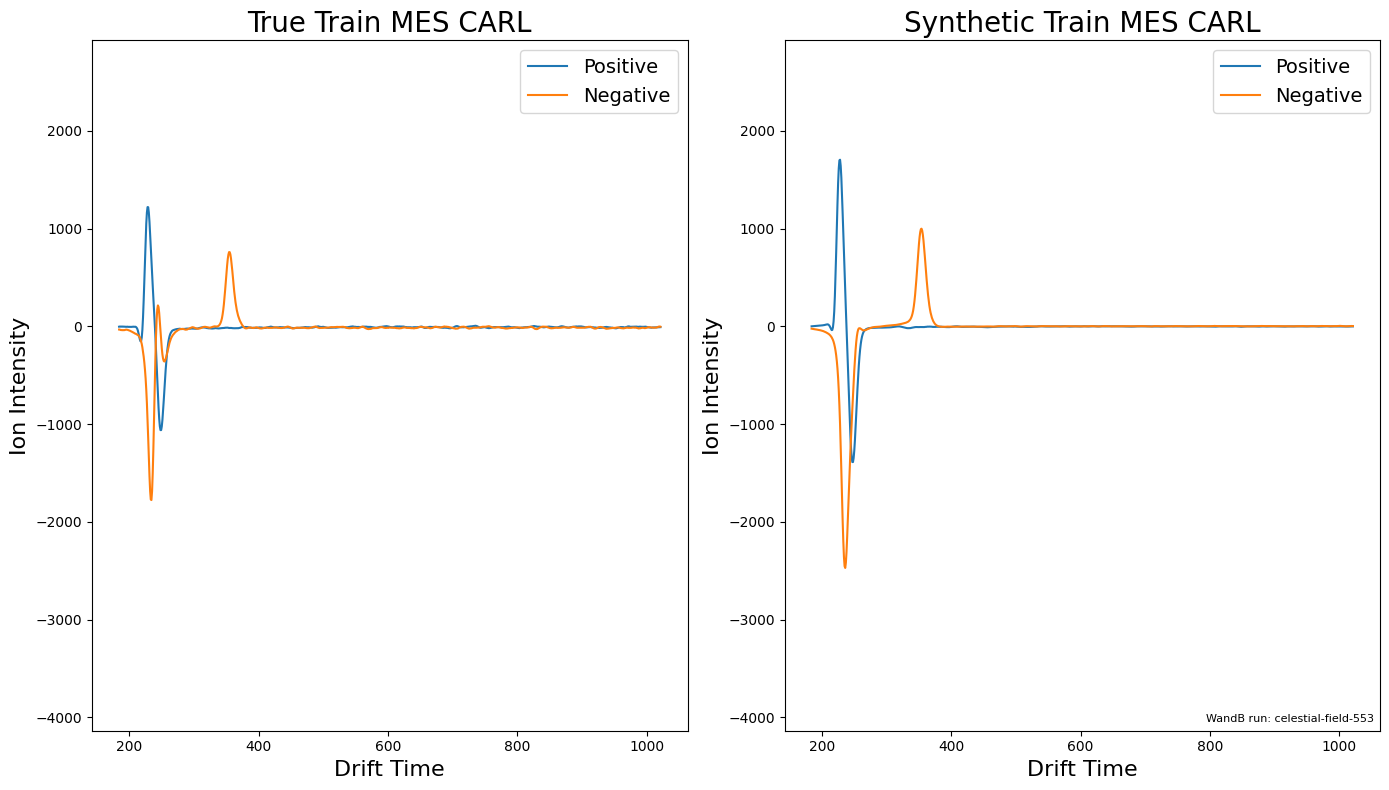

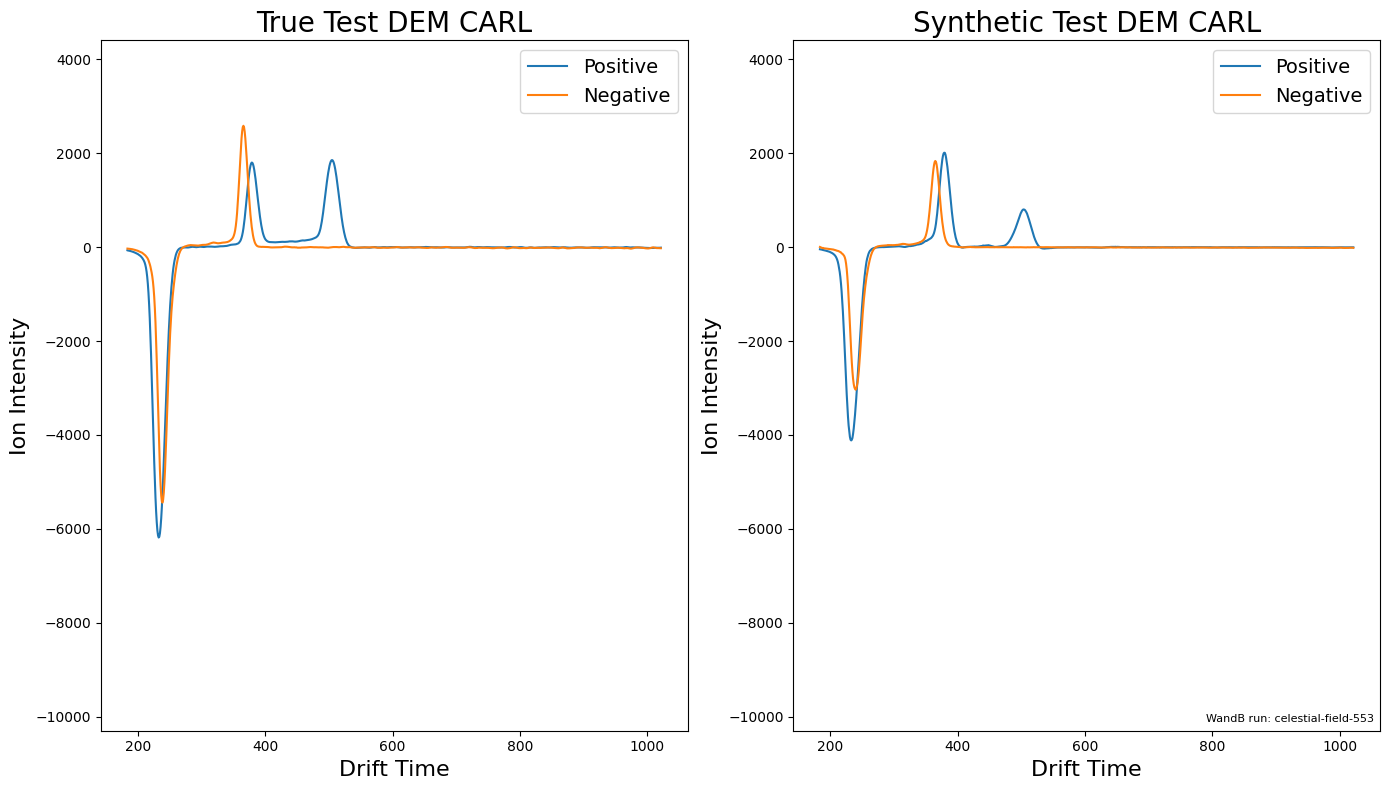

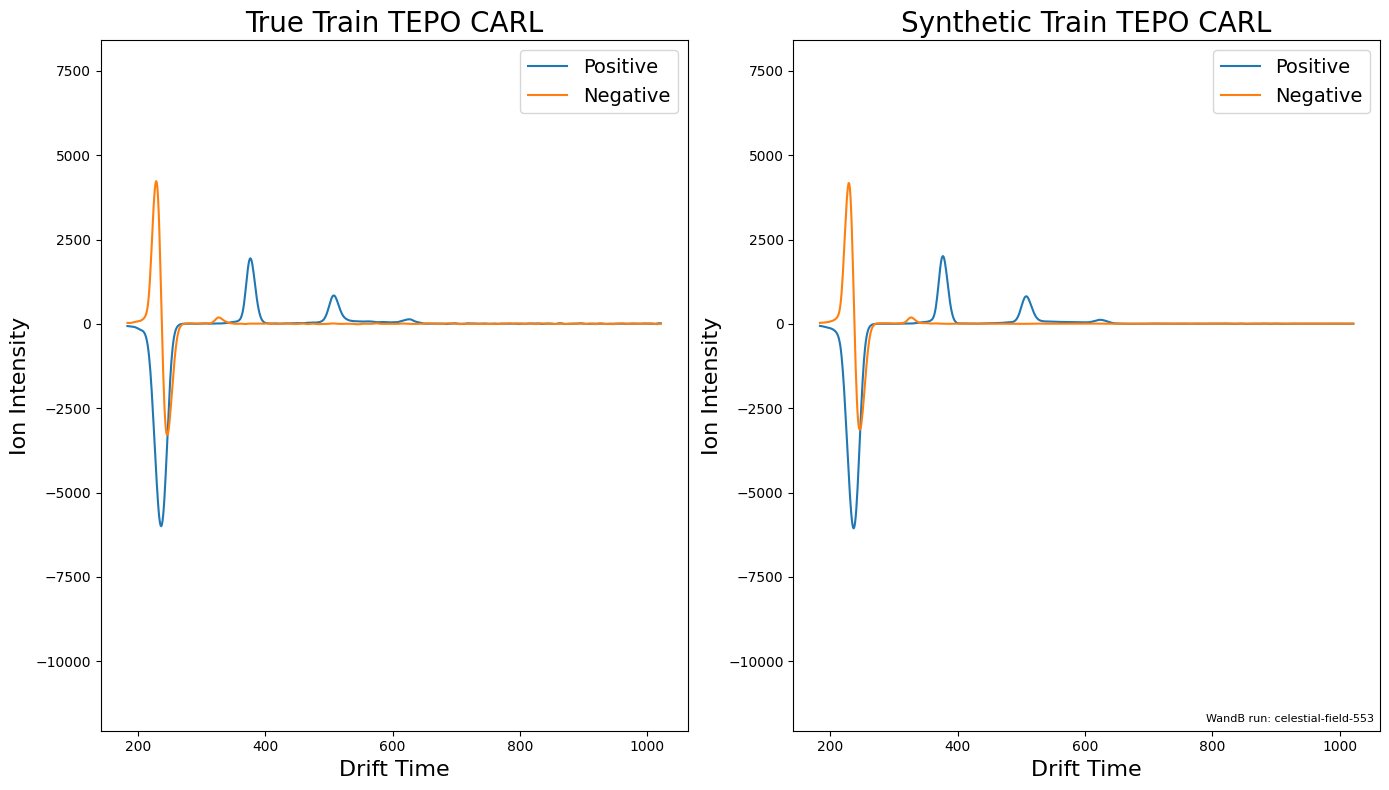

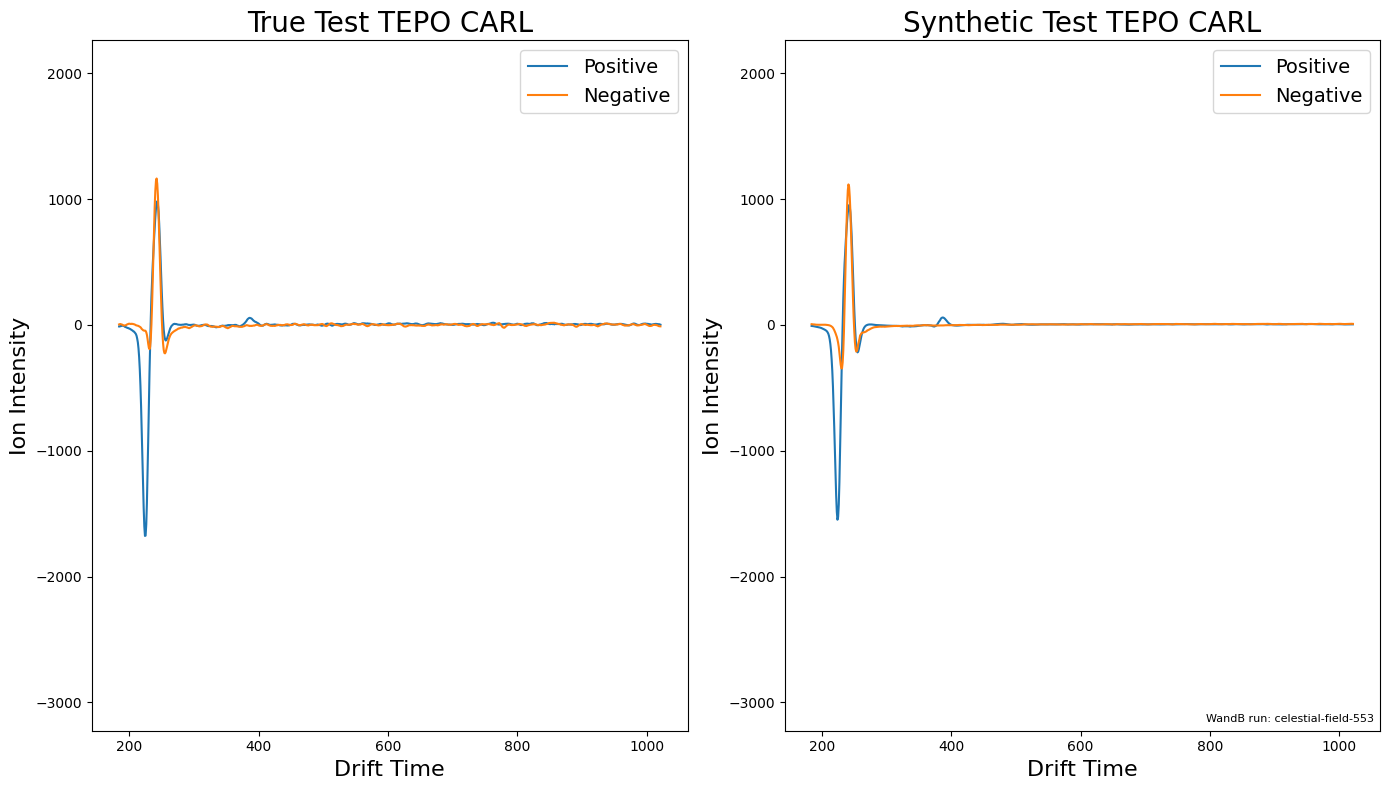

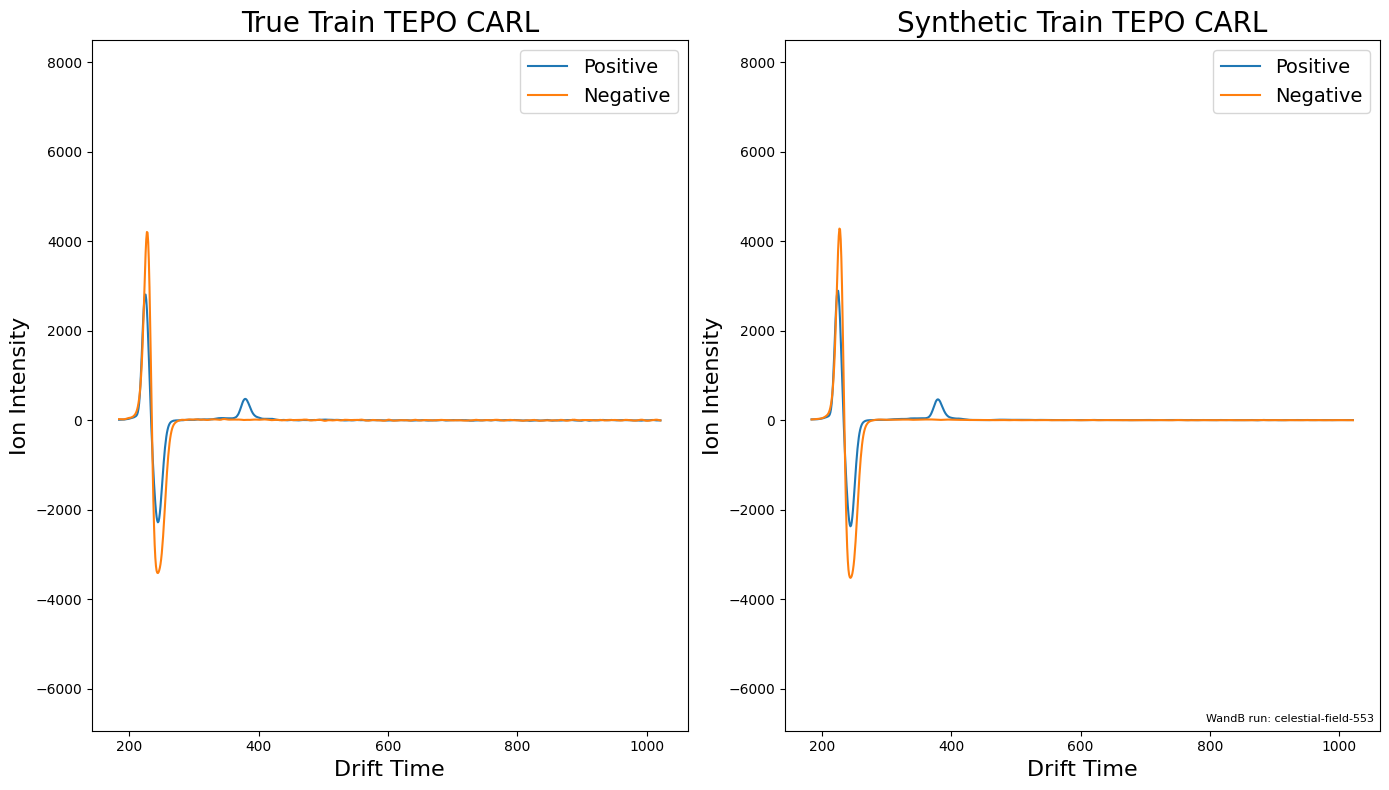

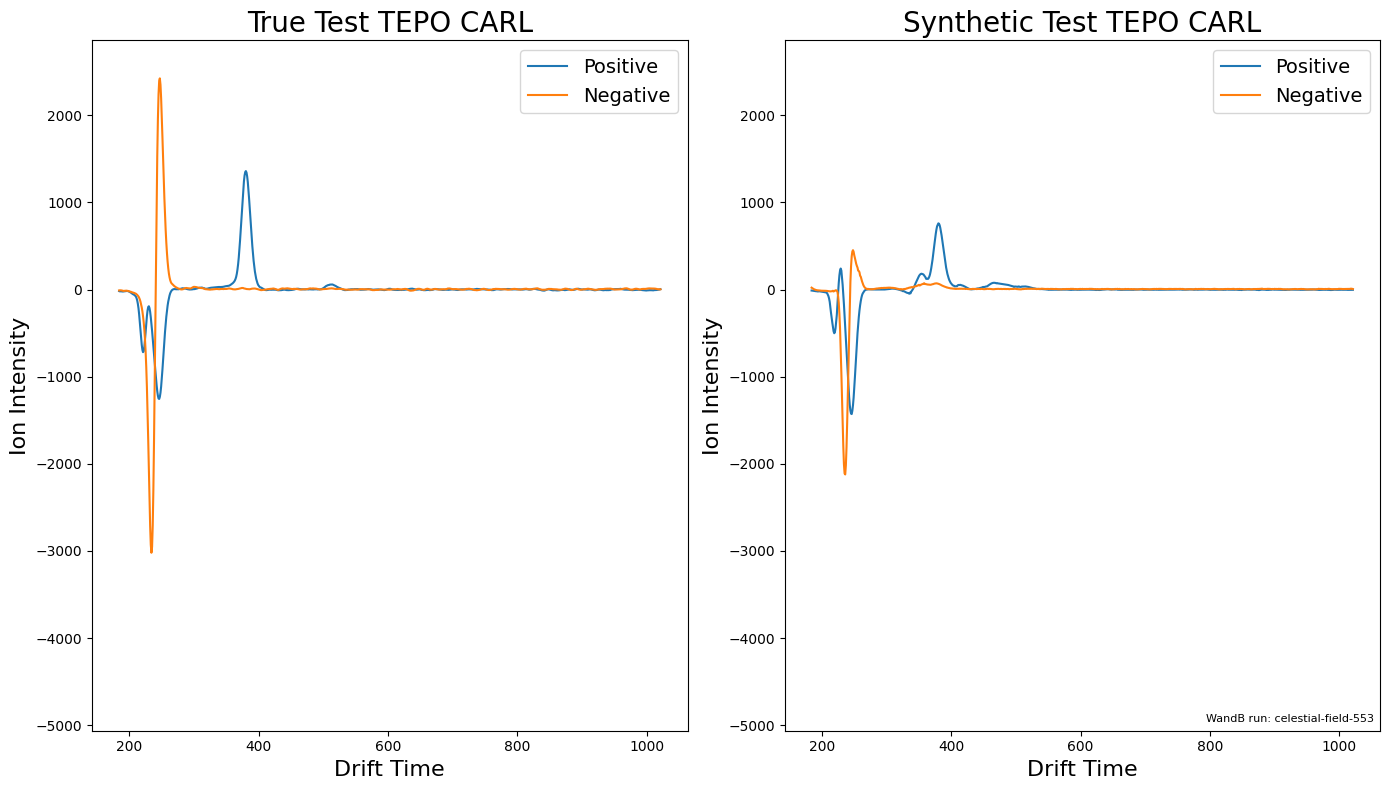

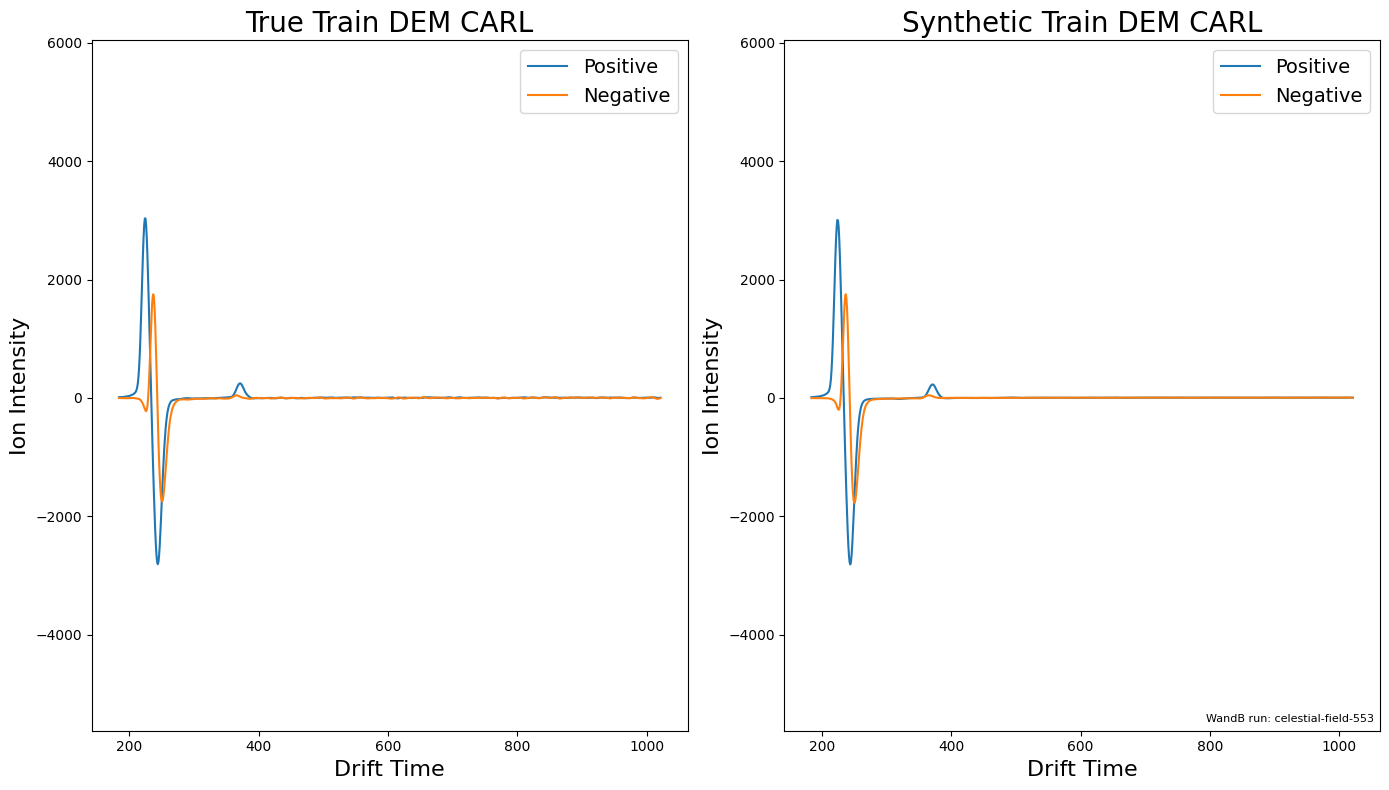

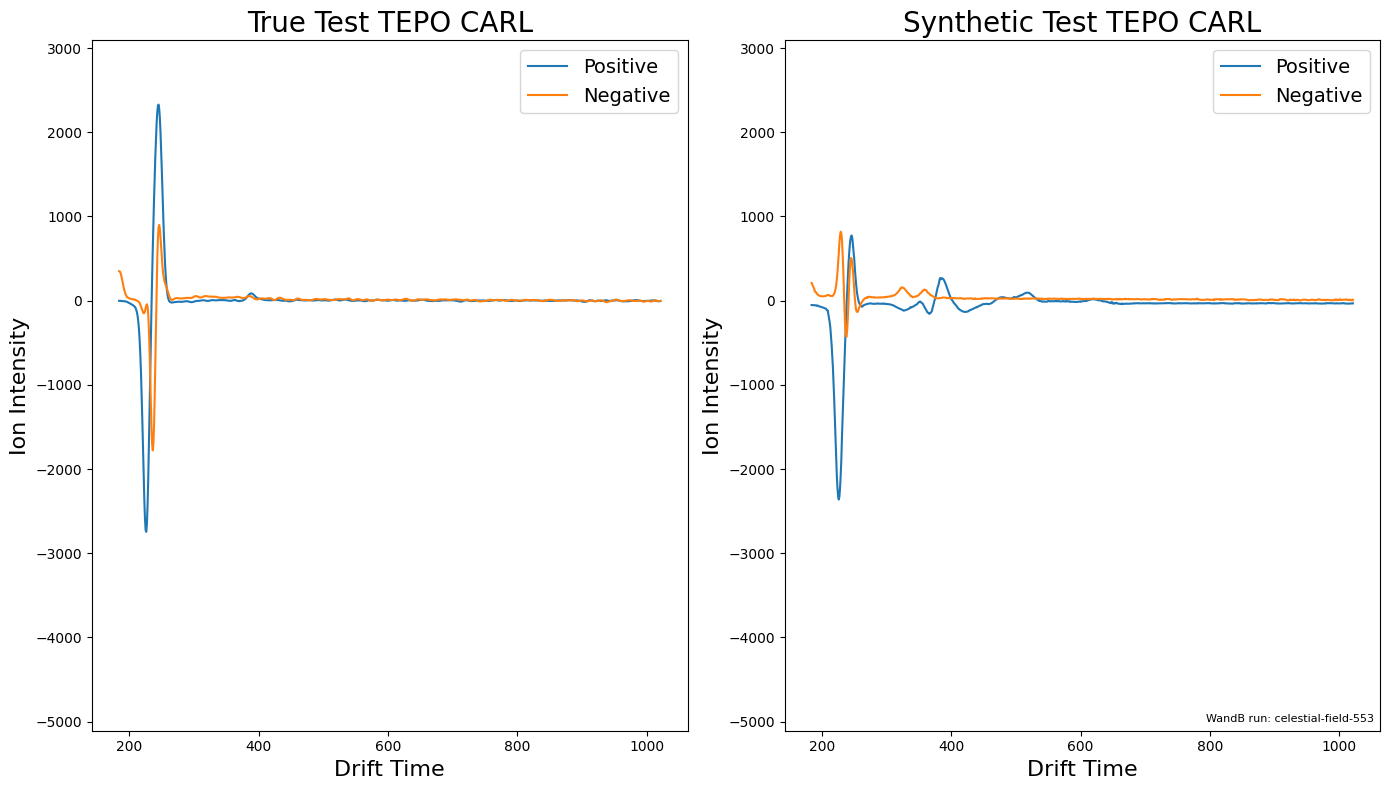

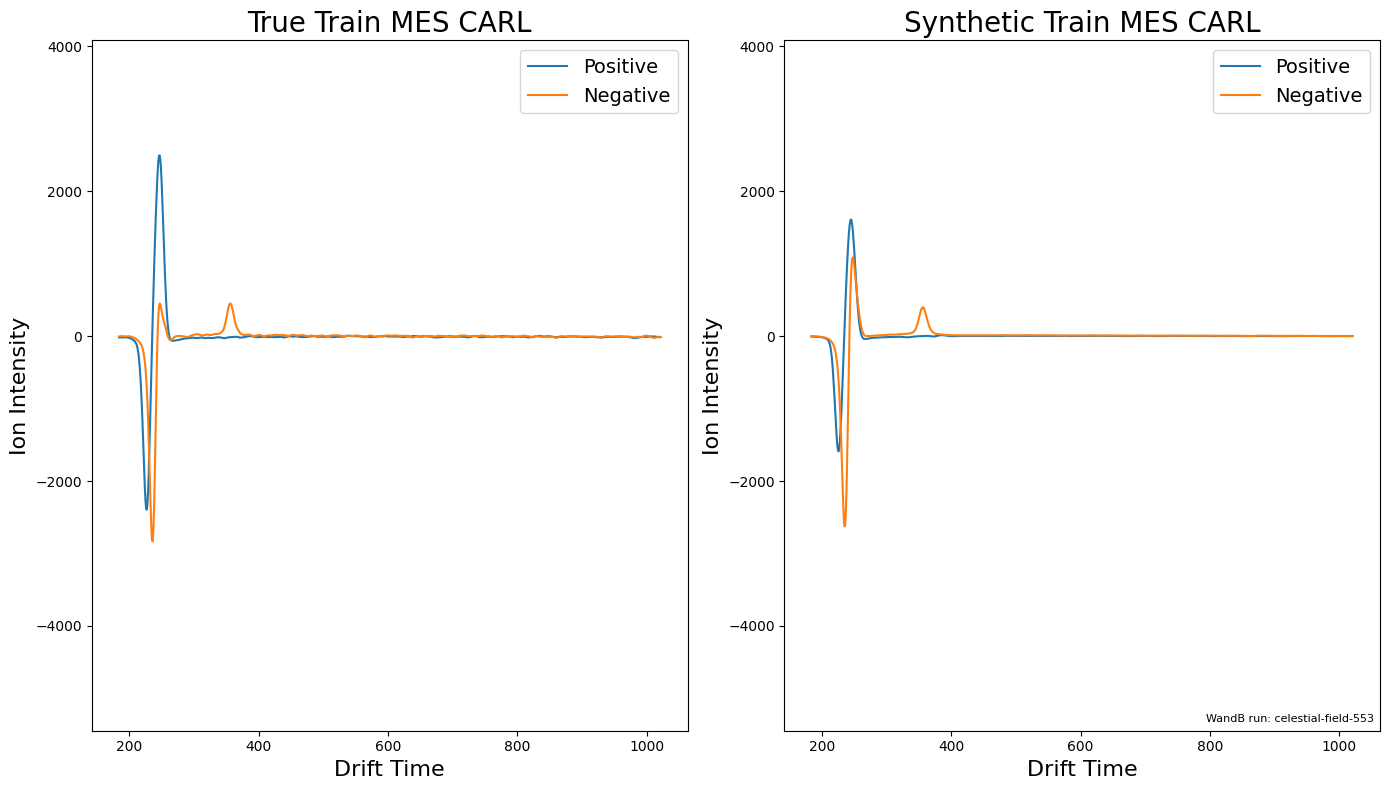

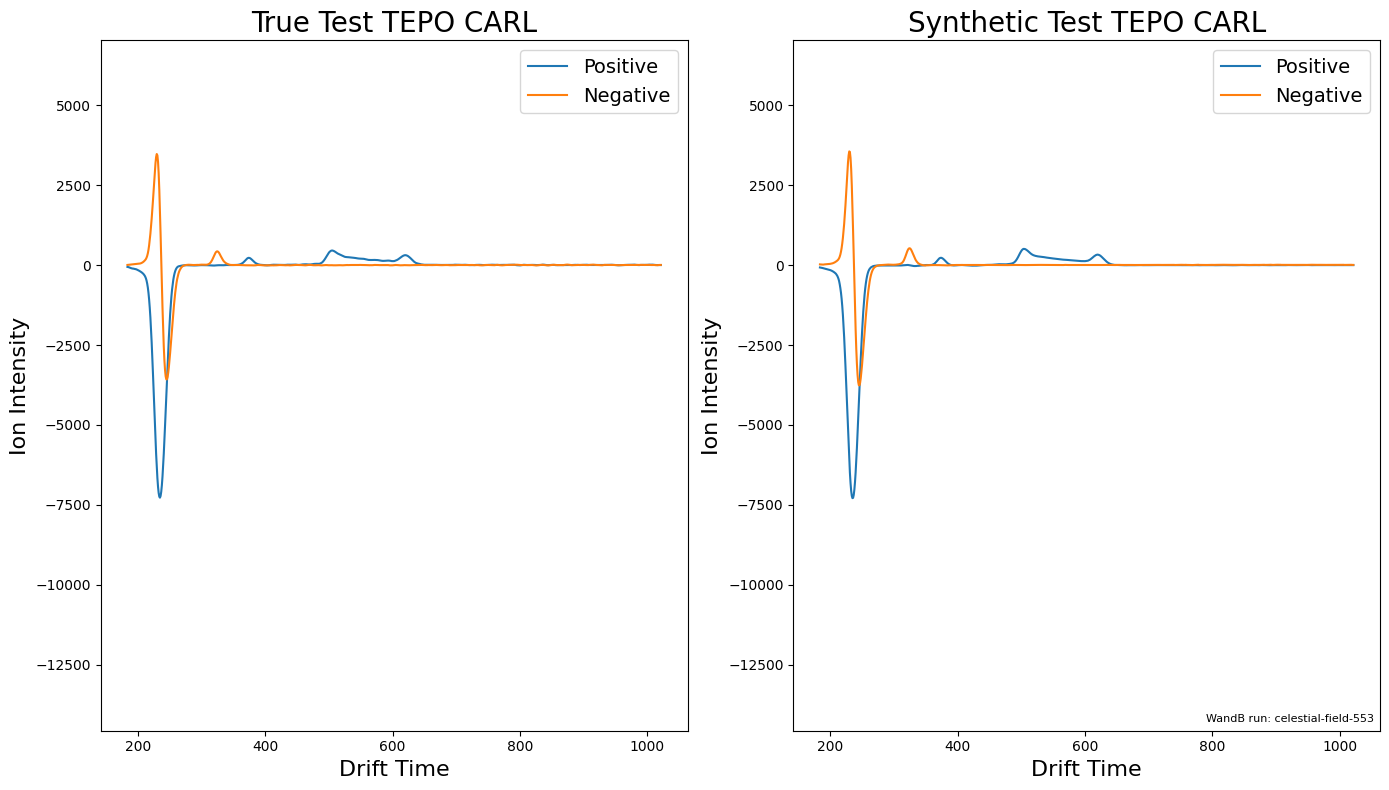

-------------------------------------------
-------------------------------------------
Dataset:  carls
Target Embeddings:  ChemNet
-------------------------------------------
-------------------------------------------
Generator(
  (encoder): Sequential(
    (0): Linear(in_features=512, out_features=652, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=652, out_features=780, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=780, out_features=908, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=908, out_features=1036, bias=True)
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Linear(in_features=1036, out_features=1164, bias=True)
    (9): LeakyReLU(negative_slope=0.01, inplace=True)
    (10): Linear(in_features=1164, out_features=1292, bias=True)
    (11): LeakyReLU(negative_slope=0.01, inplace=True)
    (12): Linear(in_features=1292, out_fe

Early Stopping Ecoch,▁
Generator Training Loss,▁▄▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Generator Validation Loss,▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Learning Rate at Final Epoch,▁
Early Stopping Ecoch,25
Generator Training Loss,8481.86455
Generator Validation Loss,57968.66106
Learning Rate at Final Epoch,0.0001


Hyperparameters for best model: 
    batch_size  :  16
    epochs  :  100
    learning_rate  :  0.01


{'batch_size': 16, 'epochs': 100, 'learning_rate': 0.01}

In [24]:
wandb_kwargs = {
    'architecture': architecture,
    'optimizer':'AdamW',
    'loss':'MSELoss',
    'dataset': dataset_type,
    'target_embedding': target_embedding
}

sorted_chem_names = list(val_carls.columns[-8:])

# model_hyperparams = {
#   'batch_size':[32, 64],
#   'epochs': [500],
#   'learning_rate':[.001, .0001],
#   }

model_hyperparams = {
  'batch_size':[16],
  'epochs': [100],
  'learning_rate':[.01],
  }

train_data = TensorDataset(train_embeddings_tensor, train_chem_encodings_tensor, train_carl_tensor, train_carl_indices_tensor)
val_data = TensorDataset(val_embeddings_tensor, val_chem_encodings_tensor, val_carl_tensor, val_carl_indices_tensor)
test_data = TensorDataset(test_embeddings_tensor, test_chem_encodings_tensor, test_carl_tensor, test_carl_indices_tensor)

f.train_generator(
    train_data, val_data, test_data, device, config, 
    wandb_kwargs, model_hyperparams, sorted_chem_names, 
    generator_path, early_stop_threshold=15, 
    lr_scheduler=True, num_plots=5
    )

## Predicting CARLs:
---

In [ ]:
device = f.set_up_gpu()
generator_path = '../models/carl_to_chemnet_generator.pth'
best_model = f.Generator().to(device)
best_model.load_state_dict(torch.load(generator_path))

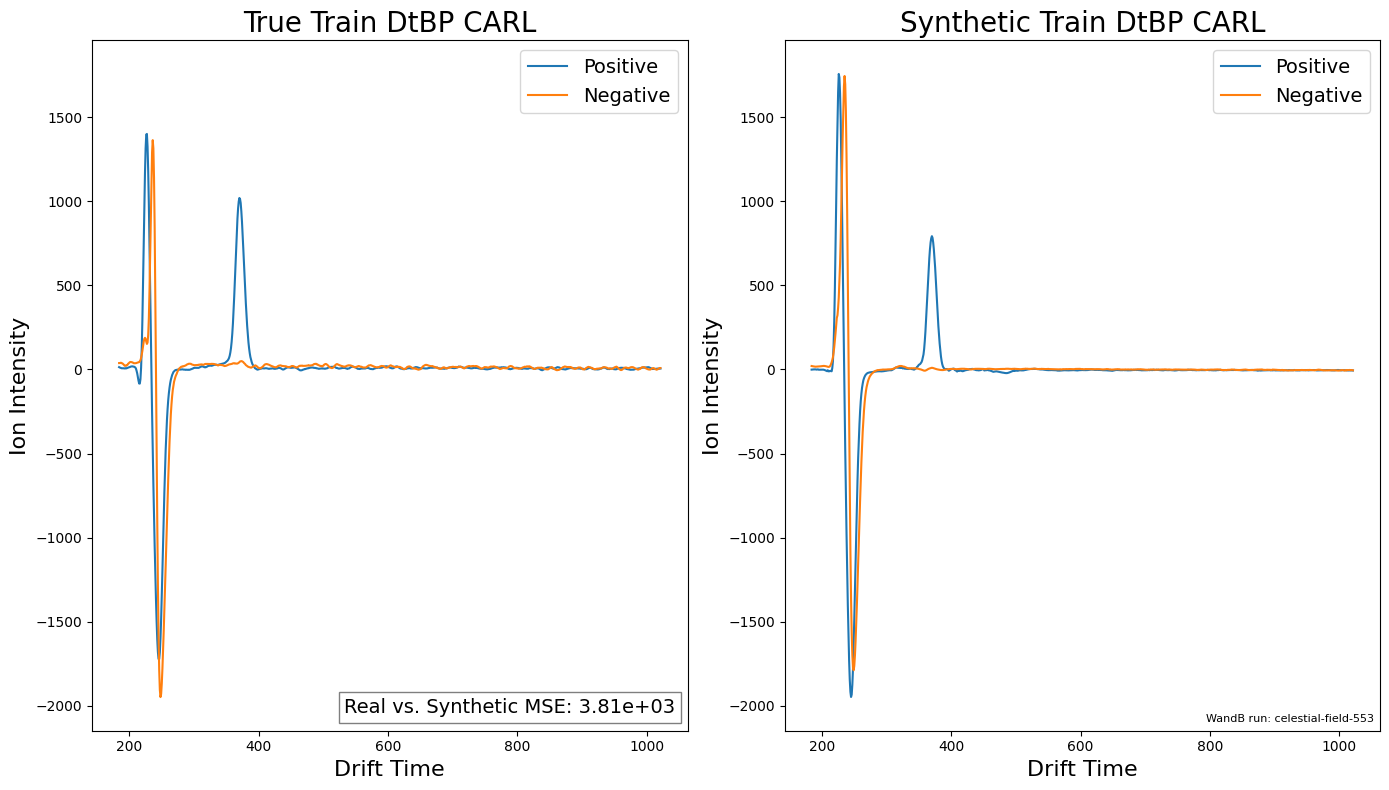

In [116]:
# Reload the functions module after updates
importlib.reload(f)

batch_size = 16
criterion = nn.MSELoss()
num_plots = 1

# get predictions from trained model and plot them
train_dataset = DataLoader(train_data, batch_size)
train_predicted_carls, train_output_name_encodings, _, _ = f.predict_embeddings(train_dataset, best_model, device, criterion)
for _ in range(num_plots):
    random_carl_num = random.randint(0, len(train_data))
    train_encodings_list = [enc for enc_list in train_output_name_encodings for enc in enc_list]
    train_predicted_carls_list = [pred for pred_list in train_predicted_carls for pred in pred_list]
    train_chem = sorted_chem_names[list(train_encodings_list[random_carl_num]).index(1)]
    f.plot_carl_real_synthetic_comparison(
        train_data[random_carl_num][2].cpu(), train_predicted_carls_list[random_carl_num], 
        'Train', train_chem, log_wandb=False, show_wandb_run_name=True, criterion=criterion, run_name='celestial-field-553')

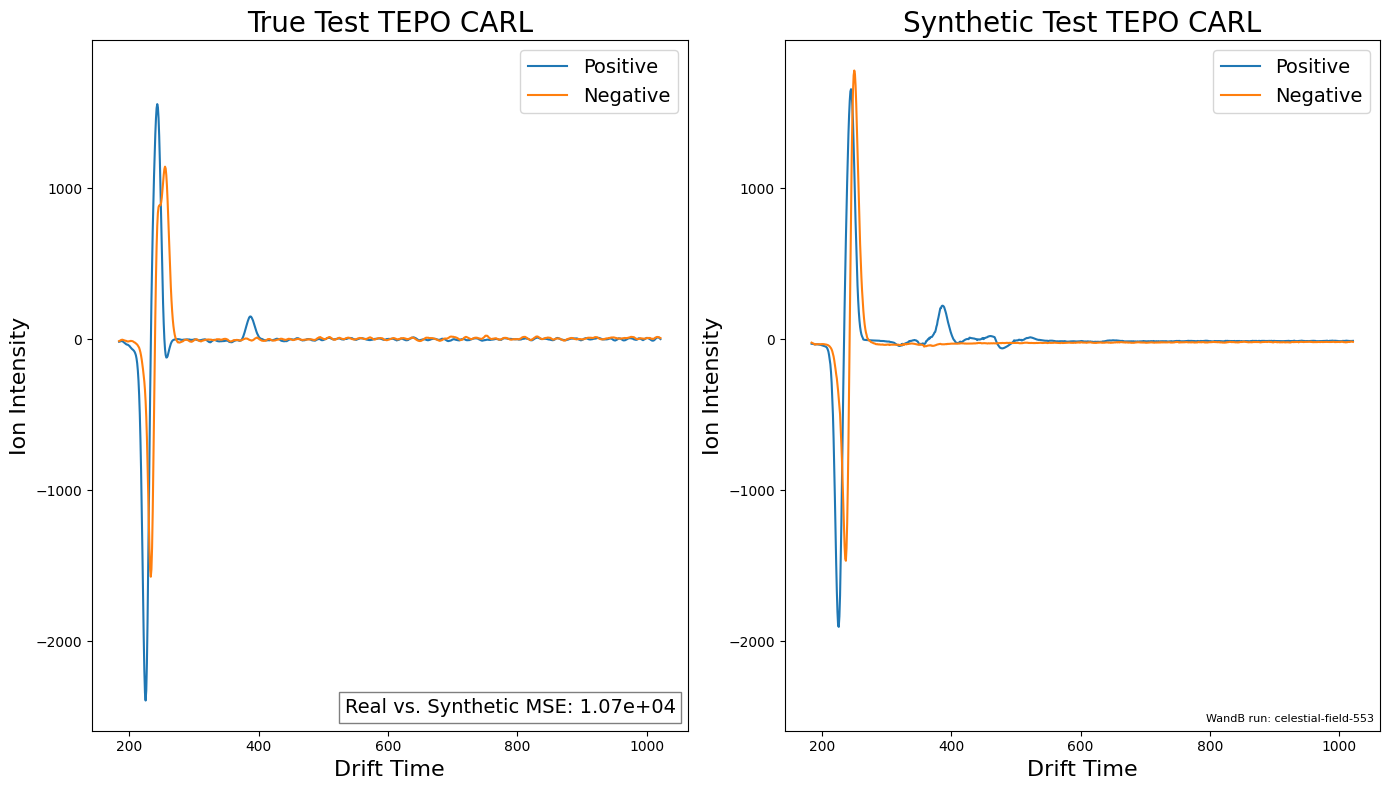

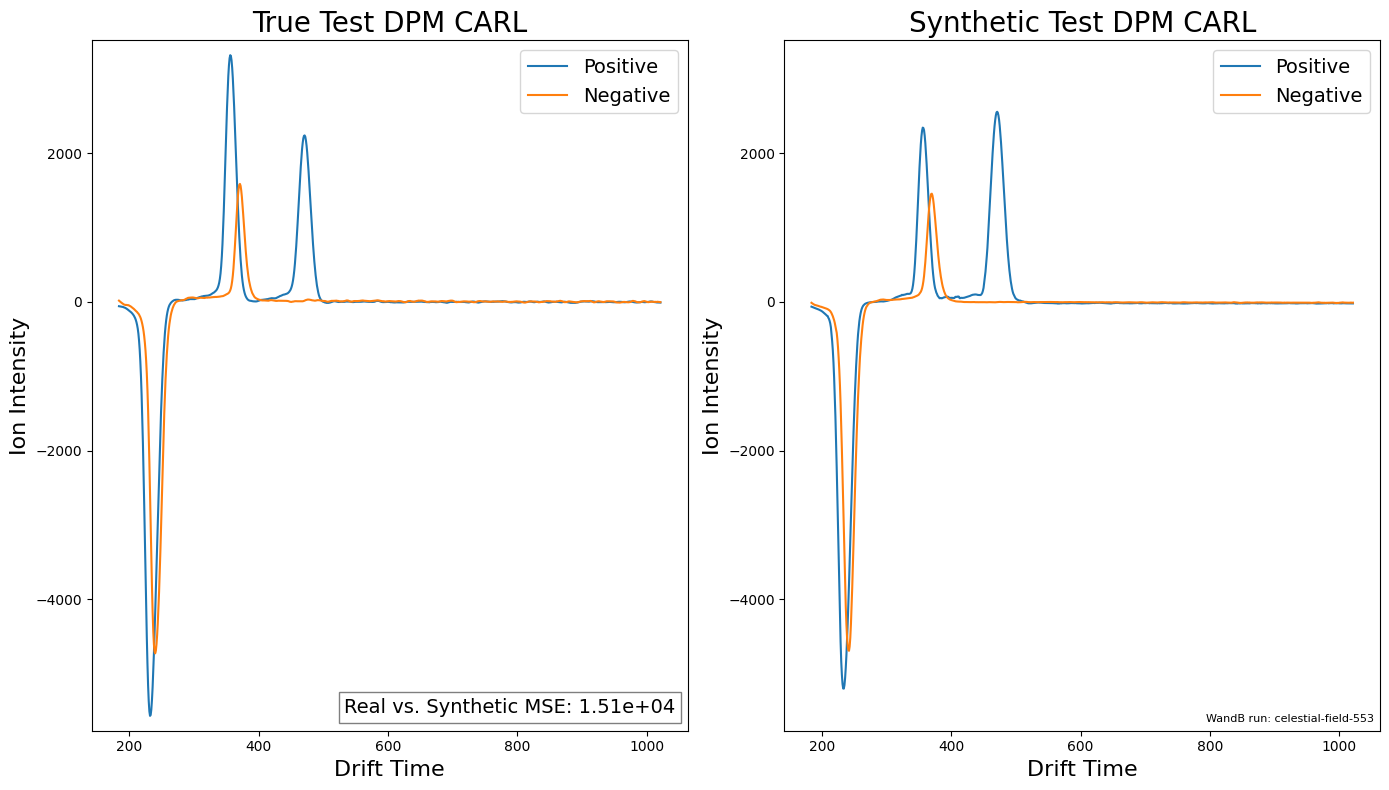

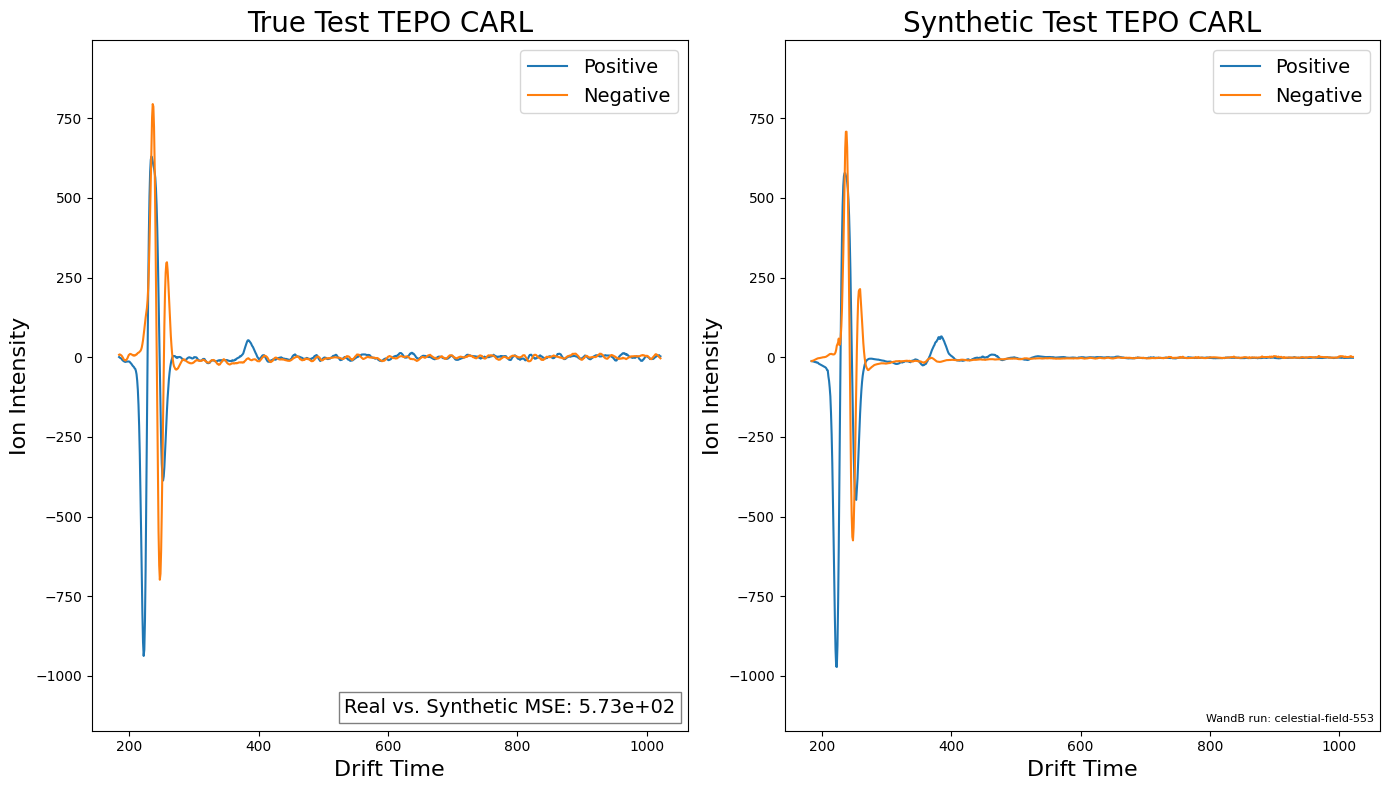

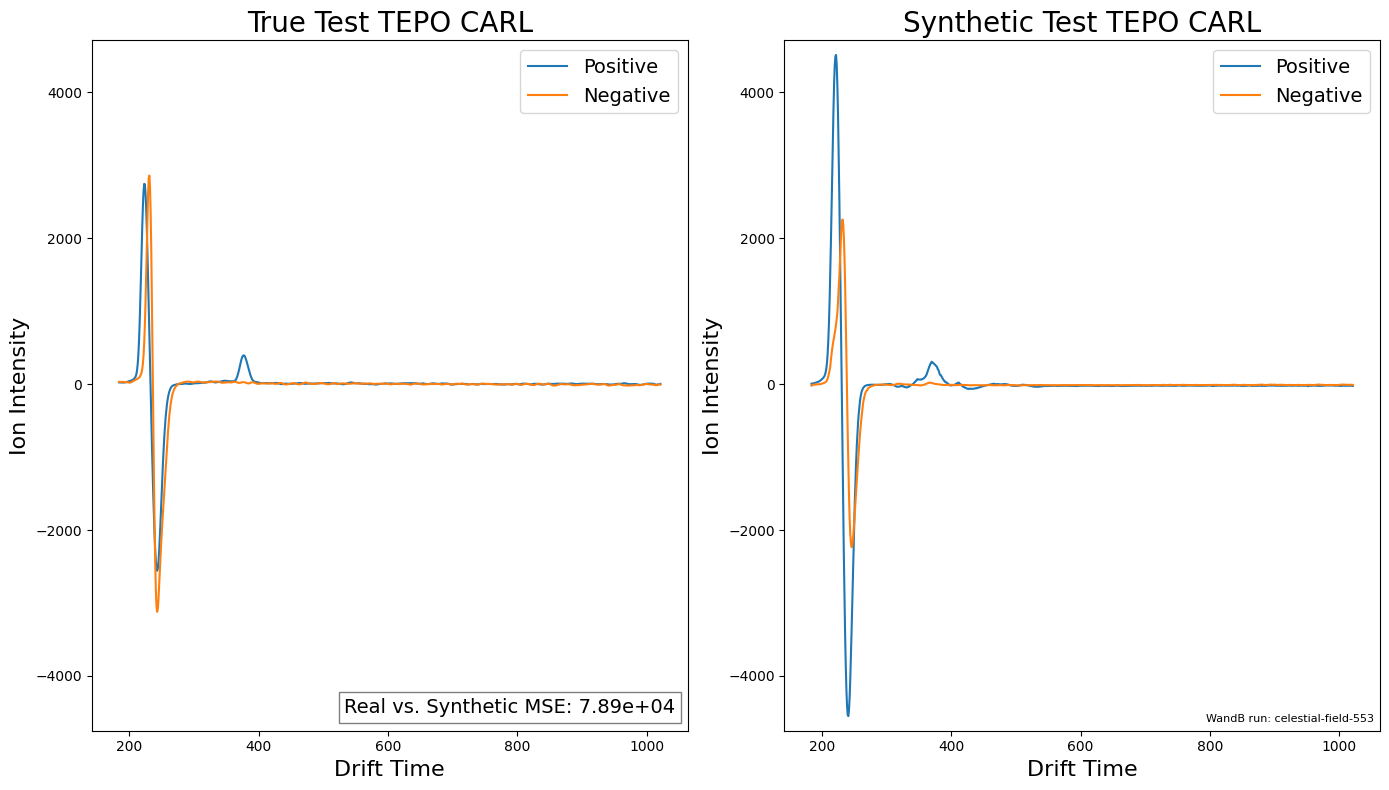

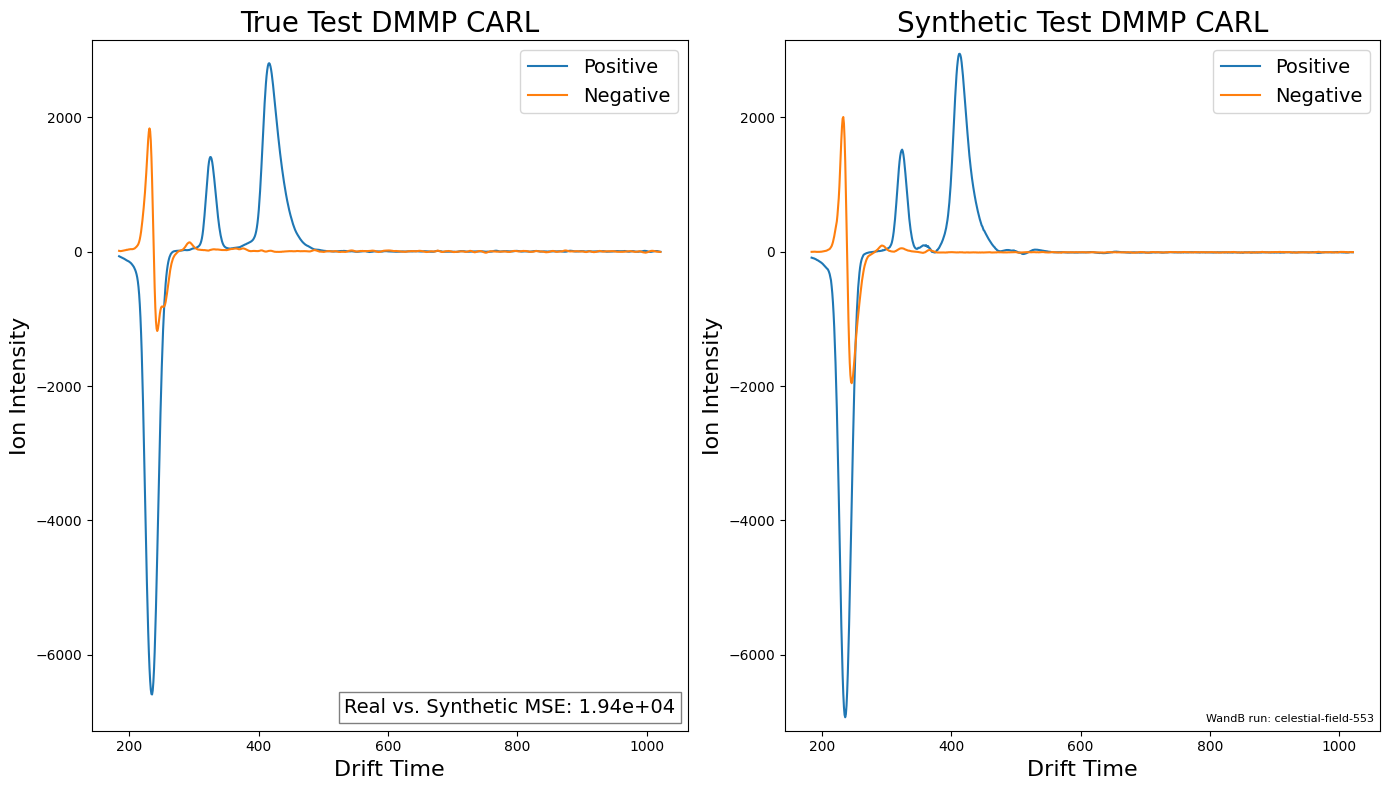

In [ ]:
# Reload the functions module after updates
importlib.reload(f)

batch_size = 16
criterion = nn.MSELoss()
num_plots = 5

test_dataset = DataLoader(test_data, batch_size)
test_predicted_carls, test_output_name_encodings, _, _ = f.predict_embeddings(test_dataset, best_model, device, criterion)
for _ in range(num_plots):
    random_carl_num = random.randint(0, len(test_data))
    test_encodings_list = [enc for enc_list in test_output_name_encodings for enc in enc_list]
    test_predicted_carls_list = [pred for pred_list in test_predicted_carls for pred in pred_list]
    test_chem = sorted_chem_names[list(test_encodings_list[random_carl_num]).index(1)]
    f.plot_carl_real_synthetic_comparison(
        test_data[random_carl_num][2].cpu(), test_predicted_carls_list[random_carl_num], 'Test', 
        test_chem, log_wandb=False, show_wandb_run_name=True, criterion=criterion, run_name='celestial-field-553')

In [118]:
generator_path = '../models/chemnet_to_carl_generator_used_for_results.pth'
torch.save(best_model.state_dict(), generator_path)

## Adding BKG spectra to create synthetic data:
---

In [2]:
def convert_carl_to_spectrum(carl_pred, spec_idx, avg_bkg_list):
    # .1 or .2 was added to the end of the carls to signify which background was used to generate them
    bkg_num = spec_idx % 1

    # get the average background spectrum that corresponds to the carl
    corresponding_bkg = avg_bkg_list[int(bkg_num)-1]

    # add predicted carl and background to get a synthetic spectrum
    synthetic_spec = carl_pred + corresponding_bkg

    return synthetic_spec


In [4]:
device = f.set_up_gpu()
generator_path = '../models/chemnet_to_carl_generator_used_for_results.pth'
best_model = f.Generator().to(device)
best_model.load_state_dict(torch.load(generator_path))

Selected GPU ID: 0
  Name: NVIDIA GeForce RTX 4090
  Memory Free: 24185.0 MB
  Memory Used: 31.0 MB
  GPU Load: 0.00%
Current device ID:  cuda:0
PyTorch current device ID: 0
PyTorch current device name: NVIDIA GeForce RTX 4090


<All keys matched successfully>

### Train:
---

In [7]:
# Loading train spectra and background spectra
file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/train_data.csv'
train_spectra = pd.read_csv(file_path)

file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/train_bkg.csv'
train_bkg = pd.read_csv(file_path)

In [9]:
# save small sample of IMS data for Steven to use 
train_spectra.sample(n=100, random_state=42).to_csv('../data/sample_of_train_ims_spectra_for_steven.csv', index=False)

In [11]:
train_embeddings_tensor, train_carl_tensor, train_chem_encodings_tensor, train_carl_indices_tensor = f.create_dataset_tensors_for_generator(train_carls, train, device)
train_data = TensorDataset(train_embeddings_tensor, train_chem_encodings_tensor, train_carl_tensor, train_carl_indices_tensor)

In [6]:
# Reload the functions module after updates
importlib.reload(f)

<module 'functions' from '/home/cmdunham/ChemicalDataGeneration/models/functions.py'>

In [7]:
n = 20
# using process from preprocerssing to get the same average background spectra used to generate the CARLs
train_background_one, train_background_two = f.generate_average_bkg_spectrum(train_bkg, n, num_avg_spectra=2)
train_background_list = [train_background_one.iloc[1:].values, train_background_two.iloc[1:].values]

In [12]:
batch_size = 16
criterion = nn.MSELoss()
num_plots = 5

train_dataset = DataLoader(train_data, batch_size)
train_predicted_carls, train_output_name_encodings, average_loss, corresponding_spectra_indices = f.predict_embeddings(train_dataset, best_model, device, criterion)

In [13]:
# combine all the predicted carls and corresponding background spectra to create synthetic spectra
preds_list = [pred for pred_list in train_predicted_carls for pred in pred_list]
indices_list = [ind for ind_list in corresponding_spectra_indices for ind in ind_list]

synthetic_spectra = []

for pred, idx in zip(preds_list, indices_list):
    synthetic_spec = convert_carl_to_spectrum(pred, idx, train_background_list)
    synthetic_spectra.append(synthetic_spec)

# Create list of chemical names for generated spectra
train_chem_encodings_list = [enc for enc_list in train_output_name_encodings for enc in enc_list]
sorted_chem_names = list(train_spectra.columns[-8:])
train_labels = [sorted_chem_names[list(enc).index(1)] for enc in train_chem_encodings_list]

synthetic_spectra_df = pd.DataFrame(synthetic_spectra)
synthetic_spectra_df['Label'] = train_labels
synthetic_spectra_df.columns = train_spectra.columns[2:-8]
synthetic_spectra_df.head()

,p_184,p_185,p_186,p_187,p_188,p_189,p_190,p_191,p_192,p_193,...,n_1013,n_1014,n_1015,n_1016,n_1017,n_1018,n_1019,n_1020,n_1021,Label
0,81.400968,84.867406,89.097416,93.384189,96.434306,100.739120,105.397074,111.062725,114.830519,120.898641,...,-16.705565,-16.399969,-16.442701,-18.016833,-17.233414,-16.878558,-15.042950,-15.068040,-15.231866,TEPO
1,79.959194,83.521926,87.767896,92.027082,95.195013,99.677052,104.269521,109.884201,113.793934,120.069139,...,-19.379187,-19.091810,-19.136212,-20.592781,-20.253130,-19.585669,-17.832900,-17.916522,-17.887386,TEPO
2,86.223306,89.106774,92.857679,95.811563,98.978691,102.200564,106.020004,111.124868,113.289001,118.785017,...,-10.455392,-10.633006,-10.144190,-10.277766,-8.249704,-8.754105,-9.962659,-9.364836,-8.622417,TEPO
3,86.876081,89.735741,93.436520,96.415678,99.534980,102.837702,106.640149,111.427187,113.852637,118.902183,...,-9.387257,-9.483519,-9.056604,-8.887443,-7.358271,-7.737629,-8.639582,-8.070443,-7.152322,TEPO
4,85.030422,87.973504,91.460661,94.343515,97.358355,101.069410,104.090008,108.703133,110.699448,115.380357,...,-12.063047,-11.771901,-11.291584,-10.736815,-8.771201,-9.213751,-10.220138,-9.655288,-9.400550,TEPO


In [14]:
file_path = '/mnt/usb/cmdunham/synthetic_data/synthetic_train_spectra.csv'
synthetic_spectra_df.to_csv(file_path, index=False)

In [5]:
# file_path = '/mnt/usb/cmdunham/synthetic_data/synthetic_train_spectra.csv'
# thing = pd.read_csv(file_path)
# thing.tail()

### Test:
---

In [2]:
# Loading test spectra and background spectra
file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/test_data.csv'
test_spectra = pd.read_csv(file_path)

In [2]:
file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/test_bkg.csv'
test_bkg = pd.read_csv(file_path)

In [23]:
# Reload the functions module after updates
importlib.reload(f)

<module 'functions' from '/home/cmdunham/ChemicalDataGeneration/models/functions.py'>

In [ ]:
n = 20
# using process from preprocerssing to get the same average background spectra used to generate the CARLs
test_background_one, test_background_two = f.generate_average_bkg_spectrum(test_bkg, n, num_avg_spectra=2)
# test_background_sample = pd.DataFrame([test_background_one, test_background_two])
test_background_list = [test_background_one.iloc[1:].values, test_background_two.iloc[1:].values]

In [128]:
batch_size = 16
criterion = nn.MSELoss()
num_plots = 5

test_dataset = DataLoader(test_data, batch_size)
test_predicted_carls, test_output_name_encodings, average_loss, corresponding_spectra_indices = f.predict_embeddings(test_dataset, best_model, device, criterion)

In [258]:
# combine all the predicted carls and corresponding background spectra to create synthetic spectra
preds_list = [pred for pred_list in test_predicted_carls for pred in pred_list]
indices_list = [ind for ind_list in corresponding_spectra_indices for ind in ind_list]

synthetic_spectra = []

for pred, idx in zip(preds_list, indices_list):
    synthetic_spec = convert_carl_to_spectrum(pred, idx, test_background_list)
    synthetic_spectra.append(synthetic_spec)

# Create list of chemical names for generated spectra
test_chem_encodings_list = [enc for enc_list in test_output_name_encodings for enc in enc_list]
sorted_chem_names = list(test_spectra.columns[-8:])
test_labels = [sorted_chem_names[list(enc).index(1)] for enc in test_chem_encodings_list]

synthetic_spectra_df = pd.DataFrame(synthetic_spectra)
synthetic_spectra_df['Label'] = test_labels
synthetic_spectra_df.columns = test_spectra.columns[2:-8]
synthetic_spectra_df.head()

,p_184,p_185,p_186,p_187,p_188,p_189,p_190,p_191,p_192,p_193,...,n_1013,n_1014,n_1015,n_1016,n_1017,n_1018,n_1019,n_1020,n_1021,Label
0,65.764336,69.367642,72.694660,76.381261,80.107734,83.117220,86.700978,92.066234,94.125514,101.267064,...,-37.213677,-37.699324,-38.343668,-37.648249,-36.459618,-36.484299,-38.263547,-37.794550,-37.079086,DEB
1,78.893726,83.245719,87.306460,91.545228,95.716795,100.203288,104.270469,111.076386,114.432432,122.426396,...,-25.631345,-25.695597,-25.841870,-23.811758,-24.085063,-23.704412,-25.057486,-24.157530,-23.879944,DEB
2,62.378163,66.174174,70.102340,73.935880,77.322778,82.426054,85.911612,93.493491,96.127314,105.798394,...,-10.782561,-11.074147,-10.720008,-9.766361,-5.973238,-3.597135,-10.373989,-8.958875,-7.872747,TEPO
3,73.752823,77.428262,80.785646,84.231951,86.317871,91.134834,94.430533,101.013740,105.239301,113.434325,...,2.864106,2.456810,2.877986,1.718761,4.438055,6.265974,2.881210,4.103479,2.900897,TEPO
4,58.072682,59.365884,61.625085,61.946729,64.892801,65.217615,69.531018,68.536674,74.162534,75.991904,...,0.515103,1.375486,0.891603,4.766513,-0.602853,-5.312446,0.679463,-0.550171,2.671079,DMMP
